<a href="https://colab.research.google.com/github/luigiselmi/algorithms/blob/master/multiclass_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiclass classification
In this notebook we will build a neural network to classify newwires from Reuters among 46 classes. Like the IMDB dataset, the link to download the Reuters dataset is directly available from Tensorflow. As for the IMDB dataset we limit the number of unique words to the 10k most used.

In [1]:
from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2110848/2110848 [==============================] - 0s 0us/step


In [3]:
print('Number of newswires for training: {:d}'.format(len(train_data)))

Number of newswires for training: 8982


In [4]:
print('Number of newswires for test: {:d}'.format(len(test_data)))

Number of newswires for test: 2246


Each newswire is provided as an array of integers, with each integer representing a word from a dictionary

In [9]:
print(train_data[0][:10])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207]


We can reconstruct the text from a newswire by inverting the dictionary

In [10]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

550378/550378 [==============================] - 0s 0us/step


In [16]:
decoded_newswire = " ".join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [17]:
train_labels[0]

3

## Multi-hot encoding
We map the training and test data into a 10k dimensionality space using the multi-hot encoding technique for which any word in our subset of the dictionary reresent a dimension and we set the coordinate of a vector representation to 1 if the word is used in the newswire and to 0 if it is not used.

In [23]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
x_train[0, :10]

array([0., 1., 1., 0., 1., 1., 1., 1., 1., 1.])

We do the same for the 46 labels so that each category is represented by a 46 dimensional vector with one coordinate set to 1 and all the rest to 0.

In [19]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

In [22]:
y_train[6]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## Multiclass classifier
The task is similar to the binary classification where we used two layers with 16 units each to classify reviews into two classes. Since here we have to classify newswires in a larger space of dimensionality 46 we'll use more units in the intermediate layers and a final layer called softmax to compute the probability for a newswire to belong to one of the 46 classes. At each layer the dimensionality of the ouput should not be lower than the dimensionality of the output of the network, 46 in our case, otherwise that layer would behave like a bottleneck.

In [25]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([
  layers.Dense(64, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(46, activation='softmax')
])

For the loss function we use the categorical crossentropy that misures the distance between the probability distribution of the model and the probability distribution of the labels. So the goal of the minimization algorithm is to change the network parameters to reduce the distance between those two probability distributions. The metrics for the performance will be the same as for the binary classification: accuracy.

In [26]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Model validation
We set apart 1k samples from the training set for validation.

In [27]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

After the architecture of the network has been defined, the model configured, and the training data prepared, we are ready to start the training

In [28]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 3s 121ms/step - loss: 2.7172 - accuracy: 0.4782 - val_loss: 1.8398 - val_accuracy: 0.6010
Epoch 2/20
16/16 [==============================] - 1s 50ms/step - loss: 1.5616 - accuracy: 0.6642 - val_loss: 1.4004 - val_accuracy: 0.6960
Epoch 3/20
16/16 [==============================] - 1s 57ms/step - loss: 1.2019 - accuracy: 0.7377 - val_loss: 1.2199 - val_accuracy: 0.7350
Epoch 4/20
16/16 [==============================] - 1s 54ms/step - loss: 0.9818 - accuracy: 0.7900 - val_loss: 1.1124 - val_accuracy: 0.7550
Epoch 5/20
16/16 [==============================] - 1s 54ms/step - loss: 0.8161 - accuracy: 0.8255 - val_loss: 1.0243 - val_accuracy: 0.7810
Epoch 6/20
16/16 [==============================] - 1s 52ms/step - loss: 0.6848 - accuracy: 0.8535 - val_loss: 0.9855 - val_accuracy: 0.7860
Epoch 7/20
16/16 [==============================] - 1s 50ms/step - loss: 0.5753 - accuracy: 0.8786 - val_loss: 0.9486 - val_accuracy: 0.8030
Epoch 8/20
1

## Model performance
We visualize the performance of the model on the training and, more importantly, on the validation set.

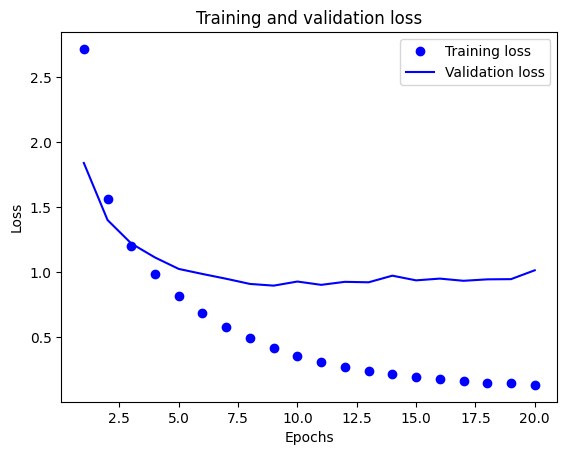

In [30]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, "b", label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

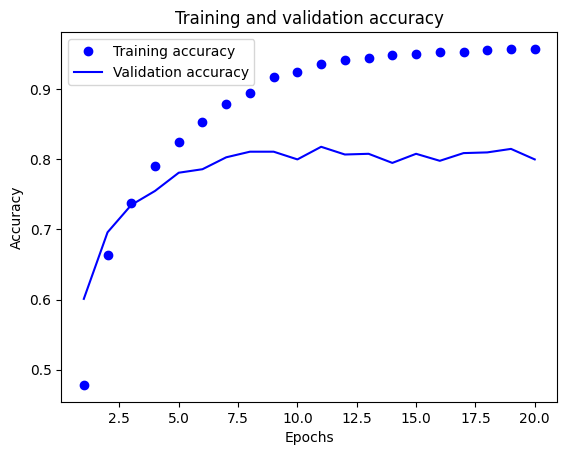

In [31]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, "bo", label='Training accuracy')
plt.plot(epochs, val_acc, "b", label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

From the plots we can see that the model loss and accuracy does not improve after 10 eopoch so we instantiate again the same model but stopping after 10 epochs

In [33]:
model = keras.Sequential([
  layers.Dense(64, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(46, activation='softmax')
])
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/10
16/16 [==============================] - 2s 69ms/step - loss: 2.7405 - accuracy: 0.4851 - val_loss: 1.8847 - val_accuracy: 0.6080
Epoch 2/10
16/16 [==============================] - 1s 52ms/step - loss: 1.5740 - accuracy: 0.6741 - val_loss: 1.4160 - val_accuracy: 0.6810
Epoch 3/10
16/16 [==============================] - 1s 50ms/step - loss: 1.1969 - accuracy: 0.7331 - val_loss: 1.2044 - val_accuracy: 0.7370
Epoch 4/10
16/16 [==============================] - 1s 47ms/step - loss: 0.9763 - accuracy: 0.7859 - val_loss: 1.1375 - val_accuracy: 0.7490
Epoch 5/10
16/16 [==============================] - 1s 51ms/step - loss: 0.8140 - accuracy: 0.8269 - val_loss: 1.0238 - val_accuracy: 0.7840
Epoch 6/10
16/16 [==============================] - 1s 51ms/step - loss: 0.6793 - accuracy: 0.8584 - val_loss: 0.9892 - val_accuracy: 0.7790
Epoch 7/10
16/16 [==============================] - 1s 71ms/step - loss: 0.5723 - accuracy: 0.8822 - val_loss: 0.9263 - val_accuracy: 0.8010
Epoch 8/10
16

In [36]:
results = model.evaluate(x_test, y_test)

71/71 [==============================] - 0s 4ms/step - loss: 0.9509 - accuracy: 0.7832


## Comparison with a random classifier
We can compare the performace of our classifier with that of a random one. We can copy the test labels, then we shuffle them and we check how many times it happens that the copied label is the same as the original one.   

In [38]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
print('Random classifier accuracy. {:.2f}'.format(hits_array.mean()))

Random classifier accuracy. 0.19


In [42]:
print('Our classifier is {:.1f} times better than the random one.'.format(results[1] / hits_array.mean()))

Our classifier is 4.2 times better than the random one.


We can see the predictions of the class membership of the newswires in the test set. each prediction is a 46 dimensional vector with the probabilities for a newswire to belong to one of the 46 classes.

In [43]:
predictions = model.predict(x_test)

71/71 [==============================] - 1s 6ms/step


In [44]:
predictions.shape


(2246, 46)

We can see that the sum of the probabilities for a prediction vector is 1 or very close it.

In [45]:
np.sum(predictions[0])

0.99999994

We assign a newswire to the class with the largest probablity

In [46]:
np.argmax(predictions[0])

3